# IMU Feature Extraction Tutorial
This notebook goes over how to extract features from IMU data collected from the Consensys software as csvs.

It will cover:
1. Loading in and reading a csv file after data collection.
2. Functions/API to extract the features.
3. Retrieving the features.
4. Epoching the data.
5. Analyzing the features.



##### !! Important Note: This notebook does not cover how to choose which features could be important/relevant. Information of how the features were curated and how they could be useful, the report/document should be consulted !!

The following is utility cell. It would otherwise be stored in a .py file to be used as a library).

In [2]:
#Utility Code

import csv
import numpy as np
from scipy.fft import fft
from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def get_imu_data(path, separation = '\t', show_details = True, fs = 512, plotting = True):
  """
  Assumes data is separate using tabs denoted by "\t" and returns a dictionary
  of data.

  @param path: path to csv file separated by tabs
  @param separation: what the csv is separated by
  @param show_details: whether a brief data descriptor is given

  Returns dictionary corresponding to data
  """

  with open(path, newline='') as f:
    reader = csv.reader(f)
    data = [row[0].split(separation) for row in reader]
  
  data = np.array(data[1:])[:,:len(data[1])-1]

  shimmer_unit = data[0][0][0:13]

  #Creating a dictionary to better describe the data
  #Changing the names to something more understandable

  imu_data = {}
  field_units = {}
  cal_status = {}

  dp = 3 #number of decimal points

  for i in range(len(data[0])):

    if(data[0][i].endswith("UNCAL")):
      data[0][i] = data[0][i][13:len(data[0][i])-6]
      cal_status.update({data[0][i]:"Uncalibrated"})
    elif(data[0][i].endswith("CAL")):
      data[0][i] = data[0][i][13:len(data[0][i])-4]
      cal_status.update({data[0][i]:"Calibrated"})
    else:
      data[0][i] = data[0][i][13:len(data[0][i])]
      cal_status.update({data[0][i]:"Calibration Status Unknown"})

    if(i > 0):
      imu_data.update({data[0][i] : np.round(data[2:,i].astype(np.float), dp)})
    else:
      imu_data.update({data[0][i] : data[2:,i]})
      
    field_units.update({data[0][i] : data[1][i]})

  if(show_details):
    print("The following fields were found:\n")
    for key in imu_data:
      print("{} : - {}, units :{}".format (
        key, cal_status[key], field_units[key]))
      
  if(plotting == True):
    tempset = set(imu_data)
    keylist = list(tempset)
    num_dp = len(imu_data[keylist[0]]) #number of datapoints
    t = np.linspace(0.0, num_dp/fs, num_dp, endpoint=False)
    if("Accel_LN_X" in tempset):
      plt.figure(figsize=(8,4))
      plt.plot(t, imu_data["Accel_LN_X"], label = "acc_ln_x")
      plt.plot(t, imu_data["Accel_LN_Y"], label = "acc_ln_y")
      plt.plot(t, imu_data["Accel_LN_Z"], label = "acc_ln_z")
      plt.legend()
    if("Accel_WR_X" in tempset):
      plt.figure(figsize=(8,4))
      plt.plot(t, imu_data["Accel_WR_X"], label = "acc_wr_x")
      plt.plot(t, imu_data["Accel_WR_Y"], label = "acc_wr_y")
      plt.plot(t, imu_data["Accel_WR_Z"], label = "acc_wr_z")
      plt.legend()
    if("Gyro_X" in tempset):
      plt.figure(figsize=(8,4))
      plt.plot(t, imu_data["Gyro_X"], label = "gyro_x")
      plt.plot(t, imu_data["Gyro_Y"], label = "gyro_y")
      plt.plot(t, imu_data["Gyro_Z"], label = "gyro_z")
      plt.legend()
    if("Mag_X" in tempset):
      plt.figure(figsize=(8,4))
      plt.plot(t, imu_data["Mag_X"], label = "mag_x")
      plt.plot(t, imu_data["Mag_Y"], label = "mag_y")
      plt.plot(t, imu_data["Mag_Z"], label = "mag_z")
      plt.legend()

  return imu_data

def fft_energy(data):
  """
  Returns the energy using fourier coefficients given an array of data that
  is in time series format. Used solely as utility/helper function

  @param data: Time series signal

  Returns float value of energy
  """

  fft_data = fft(data)
  return np.sum([np.square(element) for element in fft_data[0:len(data//2)]])

def get_peaks(data):
  """
  Returns the number of peaks of a signal

  @param data: Time series signal

  Returns num_peaks
  """

  peaks, _ = find_peaks(data, height=0)

  return len(peaks)

def get_valleys(data):
  """
  Returns the number of valleys of a signal

  @param data: Time series signal

  Returns num_valleys
  """

  valleys, _ = find_peaks(-1*(data), height=0)

  return len(valleys)

def get_single_window_stats(data_dict):
  """
  For a single window/instance or sample of data, it returns the following
  statistical features, of the Accelerometers:

  1. Energy, 2. Mean, 3. Standard Deviation, 4. Skewness, 5. Kurtosis, 
  6. Eccentricity, 7. Correlation Coefficients, 8. IQR

  @param data_dict: Must be a dict containing relevant IMU data
              -> Must be in format consistent with shimmer extraction
  """

  dict_features = {}

  for key in data_dict:
    if key.startswith('Accel'):
      dict_features.update(
        {"Mean_{}".format(key[len(key)-4 : len(key)]) : np.mean(data_dict[key])}
        )
      dict_features.update(
        {"RMS_{}".format(key[len(key)-4 : len(key)]) : np.sqrt(np.mean(data_dict[key]**2))}
        )
      dict_features.update(
        {"STD_{}".format(key[len(key)-4 : len(key)]) : np.std(data_dict[key])}
        )
      dict_features.update(
        {"Energy_{}".format(key[len(key)-4 : len(key)]) : fft_energy(data_dict[key])}
        )
      dict_features.update(
        {"Kurtosis_{}".format(key[len(key)-4 : len(key)]) : kurtosis(data_dict[key])}
        )
      dict_features.update(
        {"Skewness_{}".format(key[len(key)-4 : len(key)]) : skew(data_dict[key])}
        )
      dict_features.update(
        {"Peaks_{}".format(key[len(key)-4 : len(key)]) : get_peaks(data_dict[key])}
        )
      dict_features.update(
        {"Valleys_{}".format(key[len(key)-4 : len(key)]) : get_valleys(data_dict[key])}
        )
      
  return dict_features

def window(data, onset, period, fs):
  """
  Returns appropriate window of data based on specified time.
  It is only meant to be a helper function

  @param data: data from which we window
  @param onset: starting index - optional
  @param period: window of period in seconds
  @param fs: sampling frequency in Hz
  """

  endpoint = int(period*fs)
  return data[onset:onset+endpoint]
  
def get_stat_features(imu_data, fs, period = 6.7, plotting=True, epochs = False):
  """
  Returns sliding window features

  @param epochs : if the data is epoched or not, not means it is windowed
  """

  dict_features = {}

  keys = []
  for key in imu_data:
    keys.append(key)

  print(keys)

  if(epochs == False):
    for i in range(len(imu_data[keys[0]])- int(1.1*fs*period)):
      temp_dict = {}
      for key in imu_data:
        temp_dict.update({key : window(imu_data[key], i, period, fs)})
      single_instance = get_single_window_stats(temp_dict)
      if(i == 0):
        for key in single_instance:
          dict_features.update({key : [single_instance[key]]})
      else:
        for key in single_instance:
          dict_features[key].append(single_instance[key])
  else:
    for i in range(len(imu_data[keys[0]])):
      temp_dict = {}
      for key, val in imu_data.items():
        temp_dict.update({key : val[i]})
      single_instance = get_single_window_stats(temp_dict) #getting stats of a single epoch
      if(i == 0):
        for key in single_instance:
          dict_features.update({key : [single_instance[key]]})
      else:
        for key in single_instance:
          dict_features[key].append(single_instance[key])

  print("\nThe features we get are :")
  for key in dict_features:
    print("{}".format(key))
  print("where LN stands for Low Noise Accelerometer and WR for Wide Range Accelerometer")

  features = []
  for key in dict_features:
    features.append(key)

  if(plotting):
    fig, axs = plt.subplots(len(features)//5, 5, figsize=(20, 3.5*len(features)//5))

    index = 0
    for i in range(len(features)//5):
      for j in range(5):
        if(epochs == False):
          axs[i, j].plot(dict_features[features[index]])
          axs[i, j].set_title(features[index])
        else:
          axs[i, j].hist(dict_features[features[index]])
          axs[i, j].set_title(features[index])
        index += 1

  return dict_features
  

def get_epochs(imu_data, onset_array, period, fs):
  """
  Retrieves epochs/data samples as per the onset array/markers specify

  @param imu_data: A dictionary of imu data as specified
  @param onset_array: An array of the onset time (s)
  @param period: length of epoch/window (s)
  @param fs: sampling frequency
  """

  dict_epochs = {}

  array_indices = [int(elem*fs) for elem in onset_array]

  for key in imu_data:
    dict_epochs.update({key : []})

  for key in dict_epochs:   
     for elem in onset_array:
       dict_epochs[key].append(window(imu_data[key], elem, period, fs))

  return dict_epochs

First upload the csv file by going to the toolbar on the left and clicking on the sign that looks like a folder. Then click to the leftmost of the three to upload a file to the session.

<div> 
</div>

<div>

</div>

## 1. Now we load in the data into a dictionary
- The program will note down which fields it was able to find from the csv headings
- It will then make a full plot of the data for visualization purposes.
- This can be the first point where data analysis starts as alot of the happenings can be explained/related to kinematic/physical phenomena.
- It is best to always define the sampling frequency.
- The output will be a dictionary with the keys being the name of the 1D-Signal/Channel and the value being the time-series values in an array.

Note: the sample file shown can be downloaded from here: https://drive.google.com/file/d/12983jlE0_JX26EapCn6HbJSI-7CUnns6/view

The following fields were found:

Timestamp_Unix : - Calibrated, units :ms
Accel_LN_X : - Calibrated, units :m/(s^2)
Accel_LN_Y : - Calibrated, units :m/(s^2)
Accel_LN_Z : - Calibrated, units :m/(s^2)
Gyro_X : - Calibrated, units :deg/s
Gyro_Y : - Calibrated, units :deg/s
Gyro_Z : - Calibrated, units :deg/s
Mag_X : - Calibrated, units :local_flux
Mag_Y : - Calibrated, units :local_flux
Mag_Z : - Calibrated, units :local_flux


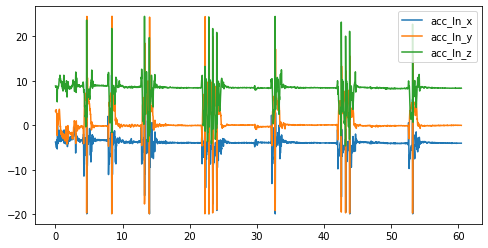

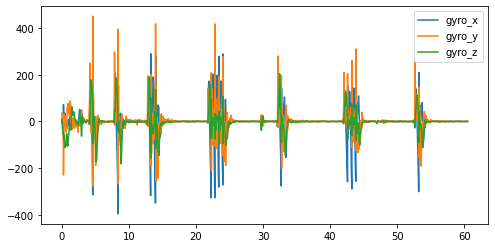

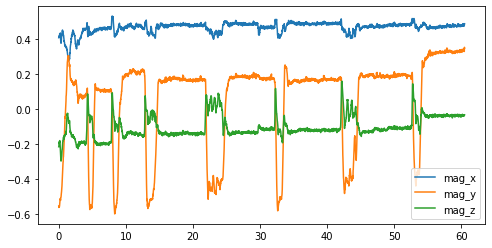

In [3]:
#First we name the file variable and the path to the directory
path_to_dir = '/content/'
file_name = 'Clapping_Session1_Shimmer_C736_Calibrated_SD.csv'

#Then we load the csv file
#Most of the arguments have defaults, but if you do not like plotting/details, it can be turned off. Please define the correct sampling frequency.
sampling_freq = 50
imu_data = get_imu_data(path=path_to_dir + file_name, separation='\t', show_details=True, fs=sampling_freq, plotting=True)


## 2. Now we extract
- The function to obtain statistical features will have multiple options as well.
- The functions we have only retrieve relevant statistical features.
- The input will need to have the dictionary of IMU-data obtained from the get_imu_data function.
- The output will also be a dictionary.

<br>
<br>


### 2.1 Sliding Window Stats Across The Whole Session
- This returns and plots (if option enabled) features displaying how they vary throughout the session full data collected.
- It will plot all the features and how they vary as the signal processes throughout the session.
- It will also list the features extracted which are the keys to the dictionary object that is output.


['Timestamp_Unix', 'Accel_LN_X', 'Accel_LN_Y', 'Accel_LN_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Mag_X', 'Mag_Y', 'Mag_Z']

The features we get are :
Mean_LN_X
RMS_LN_X
STD_LN_X
Energy_LN_X
Kurtosis_LN_X
Skewness_LN_X
Peaks_LN_X
Valleys_LN_X
Mean_LN_Y
RMS_LN_Y
STD_LN_Y
Energy_LN_Y
Kurtosis_LN_Y
Skewness_LN_Y
Peaks_LN_Y
Valleys_LN_Y
Mean_LN_Z
RMS_LN_Z
STD_LN_Z
Energy_LN_Z
Kurtosis_LN_Z
Skewness_LN_Z
Peaks_LN_Z
Valleys_LN_Z
where LN stands for Low Noise Accelerometer and WR for Wide Range Accelerometer


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


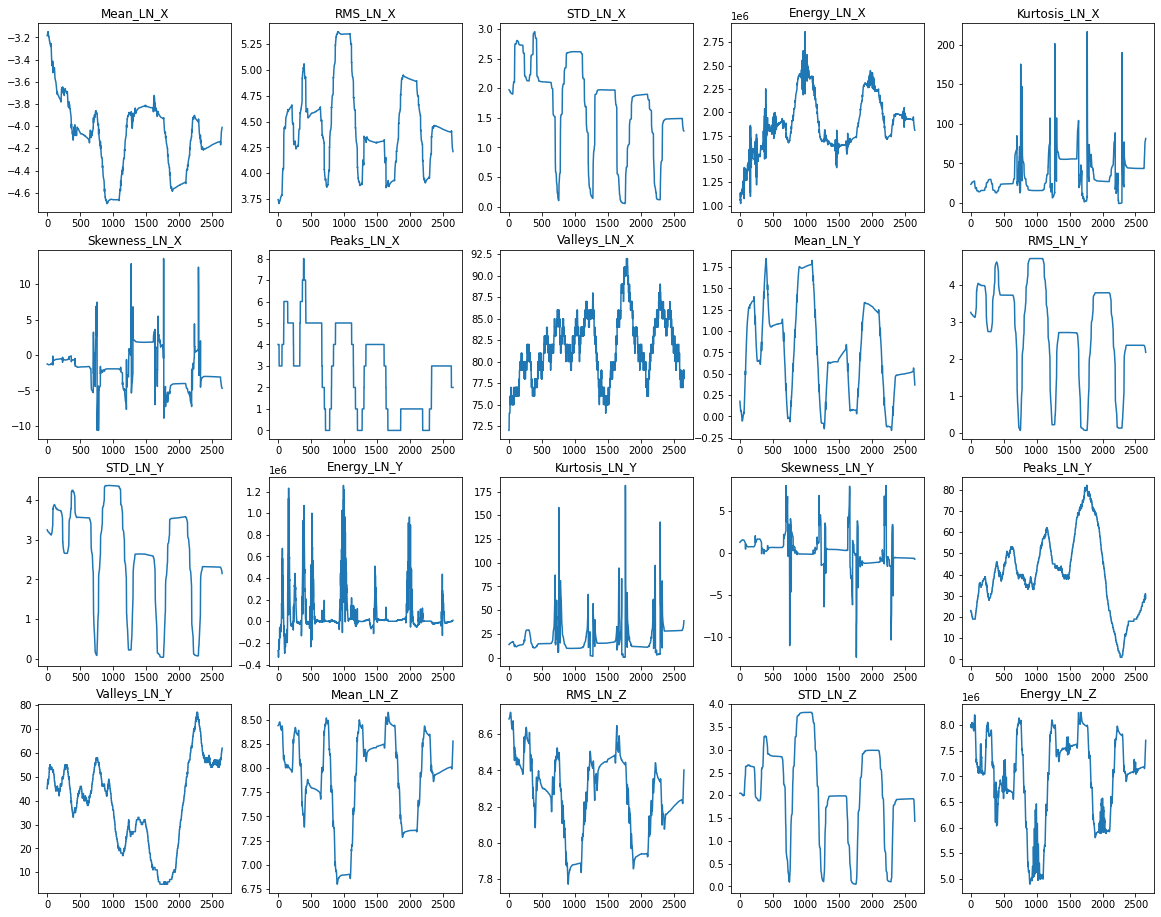

In [4]:
#Defining sampling frequency again for clarity
sampling_freq = 50

#Make sure to define the window size for the sliding window in seconds
window_size = 6.7

#Make Sure to set epochs = False for this use case

sliding_window_stats = get_stat_features(imu_data=imu_data, fs=sampling_freq, period = window_size, plotting=True, epochs = False)


### 2.2 Epoching 
- If we want to see how the signal acts at certain defined windows (that we select), that provision is also available.
- For this we would need to epoch the session.
- The epochs would all be of a fixed length starting from a given onset.
- The onset times must be defined in array which shows when an event starts.

In [5]:
#Defining the onset times for clapping
clapping_onset = [6,8,13, 20, 32, 42,53]

#Defining the onset times for not clapping
stationary_onset = [10, 17, 25, 36]

#Defining epoch size in seconds
epoch_size = 2.0

#Defining sampling frequency of data
sampling_freq = 50

#There are no defaults for epoching, getting epochs for both clapping and no-clap
clapping_epochs = get_epochs(imu_data=imu_data, 
                             onset_array=clapping_onset, 
                             period=epoch_size, fs=sampling_freq)
no_clapping_epochs = get_epochs(imu_data=imu_data, 
                             onset_array=stationary_onset, 
                             period=epoch_size, fs=sampling_freq)


### 2.3 Getting features from the epochs
- Now we use the same function for the full session stats, except we now change the setting from epochs=False to epochs=True
- Make sure to input the epoched data as an input
- If there is only 1 stat returned, there is a good chance that the whole session was input rather than the epoched data

['Timestamp_Unix', 'Accel_LN_X', 'Accel_LN_Y', 'Accel_LN_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Mag_X', 'Mag_Y', 'Mag_Z']

The features we get are :
Mean_LN_X
RMS_LN_X
STD_LN_X
Energy_LN_X
Kurtosis_LN_X
Skewness_LN_X
Peaks_LN_X
Valleys_LN_X
Mean_LN_Y
RMS_LN_Y
STD_LN_Y
Energy_LN_Y
Kurtosis_LN_Y
Skewness_LN_Y
Peaks_LN_Y
Valleys_LN_Y
Mean_LN_Z
RMS_LN_Z
STD_LN_Z
Energy_LN_Z
Kurtosis_LN_Z
Skewness_LN_Z
Peaks_LN_Z
Valleys_LN_Z
where LN stands for Low Noise Accelerometer and WR for Wide Range Accelerometer


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


['Timestamp_Unix', 'Accel_LN_X', 'Accel_LN_Y', 'Accel_LN_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Mag_X', 'Mag_Y', 'Mag_Z']

The features we get are :
Mean_LN_X
RMS_LN_X
STD_LN_X
Energy_LN_X
Kurtosis_LN_X
Skewness_LN_X
Peaks_LN_X
Valleys_LN_X
Mean_LN_Y
RMS_LN_Y
STD_LN_Y
Energy_LN_Y
Kurtosis_LN_Y
Skewness_LN_Y
Peaks_LN_Y
Valleys_LN_Y
Mean_LN_Z
RMS_LN_Z
STD_LN_Z
Energy_LN_Z
Kurtosis_LN_Z
Skewness_LN_Z
Peaks_LN_Z
Valleys_LN_Z
where LN stands for Low Noise Accelerometer and WR for Wide Range Accelerometer


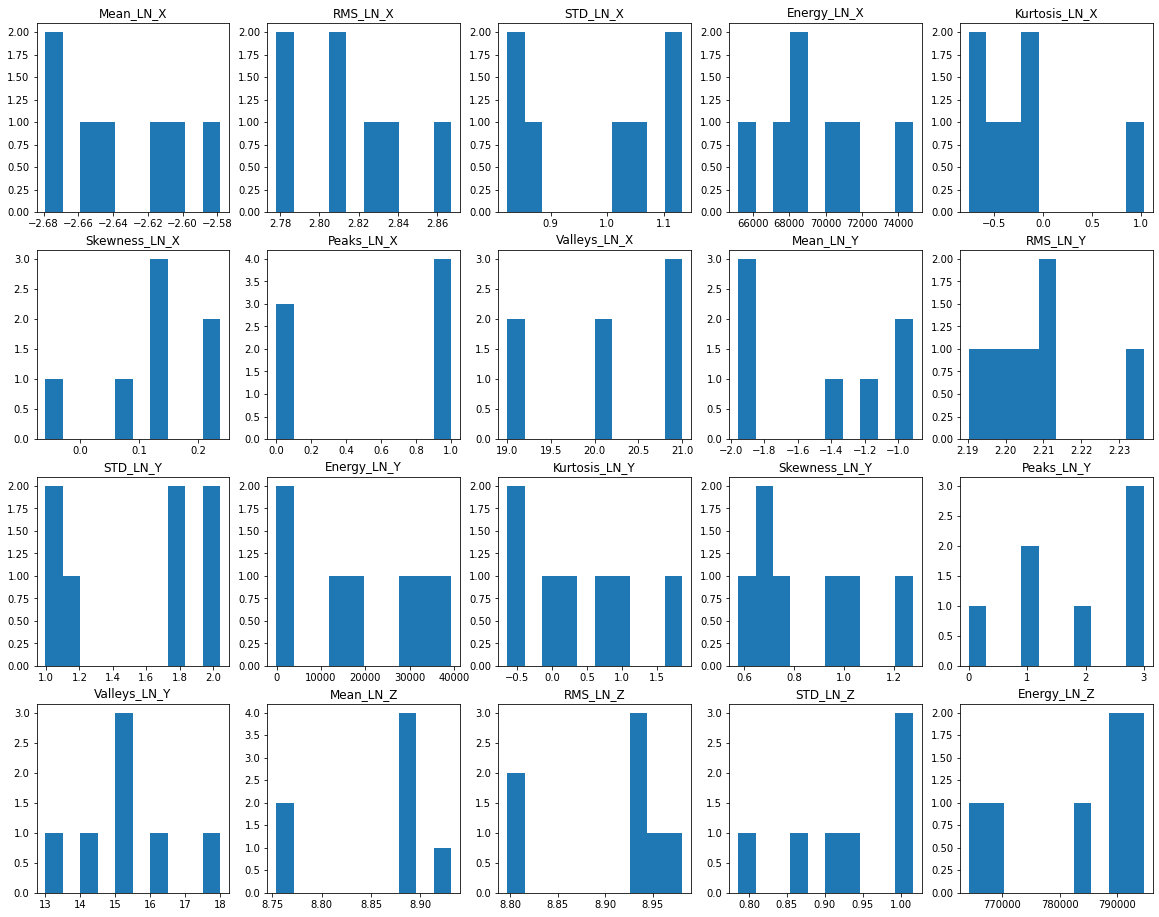

In [7]:
#Defining sampling frequency again for clarity
sampling_freq = 50

#Make sure to define the window size for the sliding window in seconds
window_size = 6.7

#Make Sure to set epochs = False for this use case
epoched_clapping_stats = get_stat_features(imu_data=clapping_epochs, fs=sampling_freq, plotting=True, epochs=True)

#Plotting only shows the histograms/bar-charts of the epoched data, so it might be better to set plotting to False
epoched_stationary_stats = get_stat_features(imu_data=no_clapping_epochs, fs=sampling_freq, plotting=False, epochs=True)

## 3. Plotting these statistics
- Having these automated quick plots is nice for a quick look, but to do more serious domain specific analysis, it might be better to get more hands on with the data.


### 3.1 First we plot the full session features
- The field itself can be gained based on the dictionary key values.
- We start off by defining a time vector for ease.
- For greater accuracy, you could pad the first N data points (based on window length) to be 0s.

Text(0.5, 1.0, 'Kurtosis Accelerometer X')

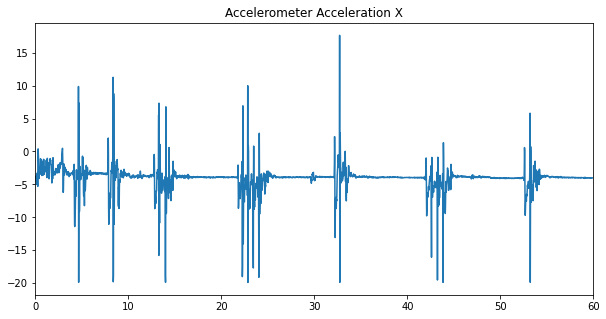

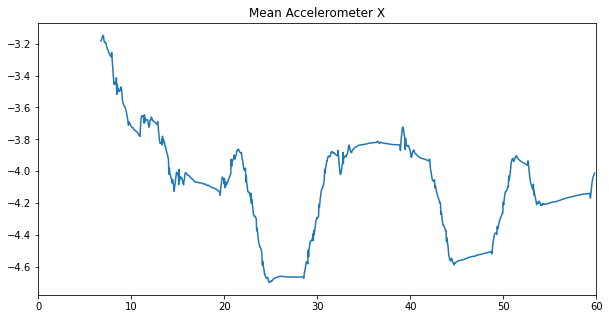

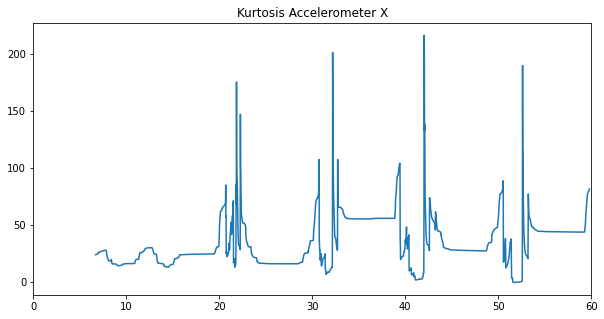

In [18]:
#Getting the specific feature we want from our extracted features
imu_acc_x = imu_data['Accel_LN_X']
mean_acc_x = sliding_window_stats['Mean_LN_X']
kurt_acc_x = sliding_window_stats['Kurtosis_LN_X']

#Defining the sampling frequency and time vector for signal and features
sampling_freq = 50
window_size = 6.7
t_signal = np.linspace(0.0, len(imu_acc_x)/sampling_freq, 
                len(imu_acc_x), endpoint=False)
t_stats = np.linspace(window_size, window_size+len(mean_acc_x)/sampling_freq, 
                len(mean_acc_x), endpoint=False)

#First we do a simple plot of the accelerometer acceleration x axis
plt.figure(figsize=(10,5))
plt.plot(t_signal, imu_acc_x)
plt.xlim(0,60)
plt.title("Accelerometer Acceleration X")

#Then we do a simple plot of the mean of the acceleration x axis sliding window
plt.figure(figsize=(10,5))
plt.plot(t_stats, mean_acc_x)
plt.xlim(0,60)
plt.title("Mean Accelerometer X")

#Then we try another simple plot of the kurtosis of the acceleration x axis sliding window
plt.figure(figsize=(10,5))
plt.plot(t_stats, kurt_acc_x)
plt.xlim(0,60)
plt.title("Kurtosis Accelerometer X")

### 3.2 Plotting epoched sessions for comparison
- Over here we try plotting epoched sessions and try making a direct comparison using boxplots using matplotlib.

['Mean_LN_X', 'RMS_LN_X', 'STD_LN_X', 'Energy_LN_X', 'Kurtosis_LN_X', 'Skewness_LN_X', 'Peaks_LN_X', 'Valleys_LN_X', 'Mean_LN_Y', 'RMS_LN_Y', 'STD_LN_Y', 'Energy_LN_Y', 'Kurtosis_LN_Y', 'Skewness_LN_Y', 'Peaks_LN_Y', 'Valleys_LN_Y', 'Mean_LN_Z', 'RMS_LN_Z', 'STD_LN_Z', 'Energy_LN_Z', 'Kurtosis_LN_Z', 'Skewness_LN_Z', 'Peaks_LN_Z', 'Valleys_LN_Z']


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

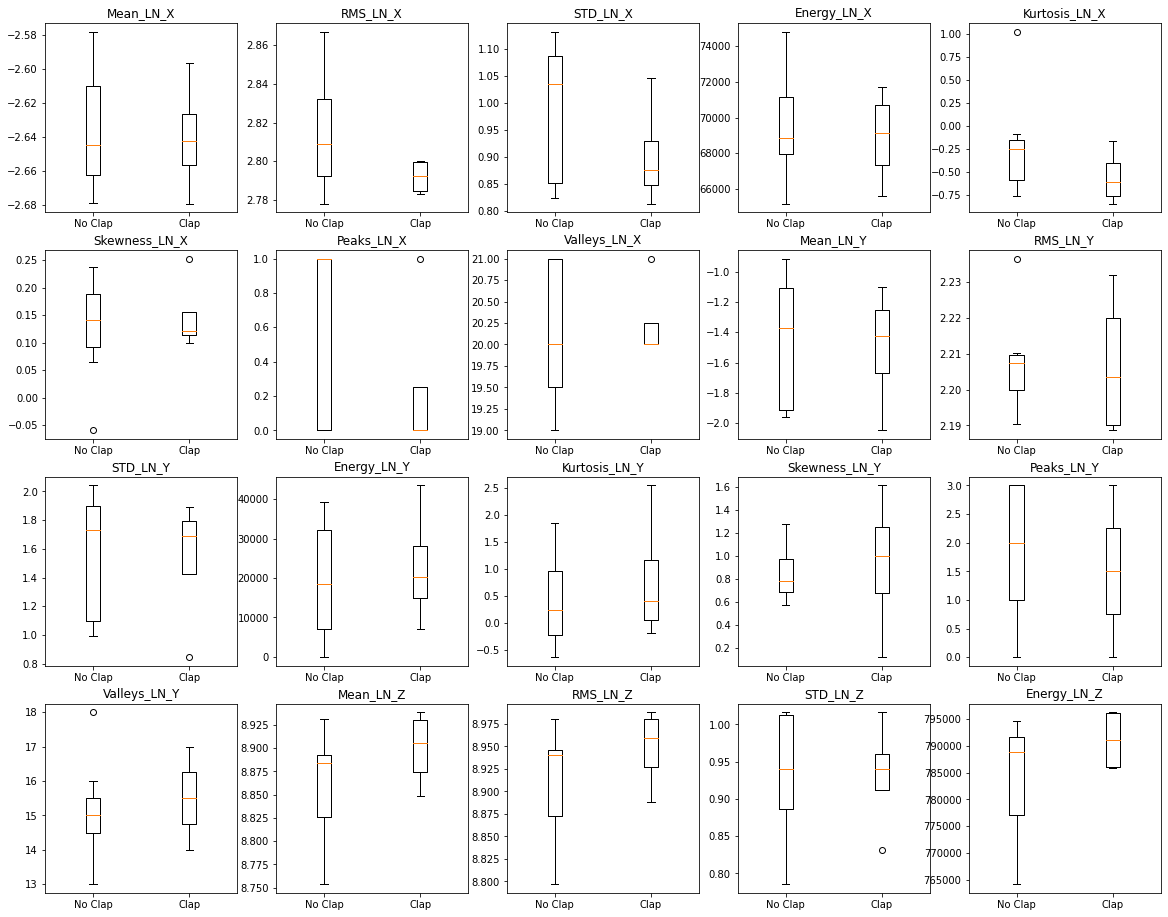

In [22]:
#First we get a list of the epoch features from the output we got earlier.
stat_names = list(epoched_clapping_stats.keys())
print(stat_names)
#
fig, axs = plt.subplots(len(stat_names)//5, 5, figsize=(20, 3.5*len(stat_names)//5))
index = 0
for i in range(len(stat_names)//5):
  for j in range(5):
      axs[i, j].boxplot([epoched_clapping_stats[stat_names[index]],
                         epoched_stationary_stats[stat_names[index]]])
      axs[i, j].set_xticklabels(["No Clap", "Clap"])
      axs[i, j].set_title(stat_names[index])
      index += 1